<a href="https://colab.research.google.com/github/MuhammadFadhilArkan/Techtest/blob/main/Q3/Transformers/Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install necessary library

In [1]:
!pip install datasets transformers rouge-score nltk
!pip install sentencepiece

     |████████████████████████████████| 290 kB 2.2 MB/s 
     |████████████████████████████████| 3.1 MB 36.0 MB/s 
     |████████████████████████████████| 243 kB 43.7 MB/s 
     |████████████████████████████████| 132 kB 51.6 MB/s 
     |████████████████████████████████| 59 kB 6.6 MB/s 
     |████████████████████████████████| 1.1 MB 40.1 MB/s 
     |████████████████████████████████| 895 kB 37.4 MB/s 
     |████████████████████████████████| 3.3 MB 39.4 MB/s 
     |████████████████████████████████| 596 kB 50.4 MB/s 
     |████████████████████████████████| 271 kB 46.1 MB/s 
     |████████████████████████████████| 192 kB 47.1 MB/s 
     |████████████████████████████████| 160 kB 49.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 2.3 MB/s 


Import the library

In [2]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML
from huggingface_hub import notebook_login
import os
from re import search
from datasets import Dataset
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_metric
from transformers import AutoTokenizer
from datasets import ClassLabel, Features, Value
import tensorflow as tf
from transformers import create_optimizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import seaborn as sns

login to huggingface

In [3]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-crendential store but this isn't the helper defined on your machine.
You will have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal to set it as the default

git config --global credential.helper store


In [4]:
!apt install git-lfs
!git config --global user.email "arkanfadhil080@gmail.com"
!git config --global user.name "fadhilarkan"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (1,979 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.3.4-1_amd64.deb ...
Unpacking git-lfs (2.3.4-1) ...
Setting up git-lfs (2.3.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Define the parameter for the pre trained model

In [5]:
task = "cola"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

Define the path of the text file

In [6]:
path= "/content/drive/MyDrive/CAD IT/Machine Learning Application Engineer Test 2021 V1.1/Q3/"

Read the text file

In [7]:
arr = os.listdir(path)
strtxt = ".txt"
datas = []
for txtfile in arr:
    if txtfile.__contains__(strtxt):
        fileObject = open(path+txtfile, "r")
        data = fileObject.read()
        datas.append(data)

Extract only needed sentence from the files by cleaning sentence that start with "#"

In [8]:
ds = []
for data in datas :
  text = datas[0].split("\n")
  for item in text:
    if ((len(item)>0) and (item[0] != "#")):
      ds.append(item)

Separate each sentence into label and sentence

In [9]:
labels = []
sentences = []
for item in ds :
  label = item[:4]
  sentence = item[4:]

  labels.append(label)
  sentences.append(sentence)

Make a pandas dataframe from the labels and sentences for sake of visualization

In [10]:
data_dict = {"label": labels, "sentence": sentences}
df = pd.DataFrame(data_dict)
df

,label,sentence
0,AIMX,We propose a nonparametric Bayesian factor re...
1,BASE,"To accomplish this, we propose a sparse varia..."
2,OWNX,We apply this model to two problems (factor a...
3,MISC,Factor analysis is the task of explaining dat...
4,MISC,Factor regression couples this analysis wit...
...,...,...
2065,OWNX,Since our motivation is an application in bio...
2066,OWNX,"In particular, genes are features , sampl..."
2067,OWNX,"However, our model is more general"
2068,OWNX,An alternative application might be to a coll...


As we can see the data is already cleaned, but lets check the distribution of labels

In [11]:
print(f"Value counts for each class:\n\n{df.label.value_counts()}\n")

Value counts for each class:

OWNX    1350
MISC     450
AIMX      90
BASE      90
CONT      90
Name: label, dtype: int64



We can see that this is an unbalanced dataset, so we have to do the train_test split correctly by using "stratify" option from scikit library

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.sentence, df.label, test_size=0.2, random_state=42, stratify=labels)

Check the distribution of labels on each train and test set

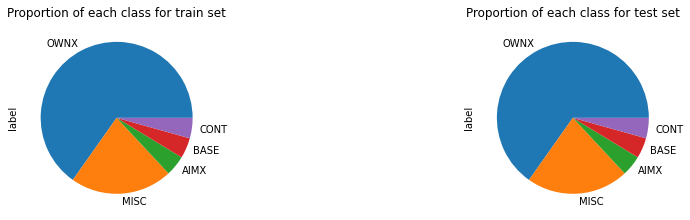

In [13]:
plt.subplot(1, 3, 1)
y_train.value_counts().plot.pie(y='label', title='Proportion of each class for train set', figsize=(10, 6))

plt.subplot(1, 3, 3)
y_test.value_counts().plot.pie(y='label', title='Proportion of each class for test set', figsize=(10, 6))

plt.tight_layout()
plt.show()

Yes, the train and test set is balanced

Now, lets transform our data into huggingface datasets

First, define the name of each class

In [14]:
class_names = ["AIMX", "OWNX", "CONT", "BASE", "MISC"]
features = Features({'sentence': Value('string'), 'label': ClassLabel(names=class_names)})

Create the datasets

In [15]:
train_dict = {"label": y_train, "sentence": X_train}
eval_dict = {"label": y_test, "sentence": X_test}

train_data = Dataset.from_dict(train_dict, features=features)
eval_data = Dataset.from_dict(eval_dict, features=features)

Sanity check on the datasets

In [16]:
train_data.features

{'label': ClassLabel(num_classes=5, names=['AIMX', 'OWNX', 'CONT', 'BASE', 'MISC'], names_file=None, id=None),
 'sentence': Value(dtype='string', id=None)}

Utility function to visualize datasets

In [17]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

Visualize training set

In [18]:
show_random_elements(train_data)

,label,sentence
0,MISC,Factor analysis is the task of explaining data by means of a set of latent factors
1,OWNX,"In particular, genes are features , samples are examples , and pathways are factors"
2,OWNX,"In particular, genes are features , samples are examples , and pathways are factors"
3,OWNX,"In particular, genes are features , samples are examples , and pathways are factors"
4,CONT,We address three fundamental shortcomings of standard factor analysis approaches CITATION : (1) we do not assume a known number of factors; (2) we do not assume factors are independent; (3) we do not assume all features are relevant to the factor analysis
5,OWNX,"Since our motivation is an application in bioinformatics, our notation and terminology will be drawn from that area"
6,OWNX,Our factor regression model is fundamentally nonparametric
7,MISC,Factor analysis is the task of explaining data by means of a set of latent factors
8,MISC,The latent factor representation achieves two-fold benefits: (1) discovering the latent process underlying the data; (2) simpler predictive modeling through a compact data representation
9,MISC,"Factor regression couples this analysis with a prediction task, where the predictions are made solely on the basis of the factor representation"


Visualize evaluation set

In [19]:
show_random_elements(eval_data)

,label,sentence
0,OWNX,Our contributions thus parallel the needs of gene pathway modeling
1,BASE,"To accomplish this, we propose a sparse variant of the Indian Buffet Process and couple this with a hierarchical model over factors, based on Kingman's coalescent"
2,OWNX,"Since our motivation is an application in bioinformatics, our notation and terminology will be drawn from that area"
3,OWNX,"In particular, genes are features , samples are examples , and pathways are factors"
4,OWNX,"However, our model is more general"
5,MISC,The latent factor representation achieves two-fold benefits: (1) discovering the latent process underlying the data; (2) simpler predictive modeling through a compact data representation
6,AIMX,"We propose a nonparametric Bayesian factor regression model that accounts for uncertainty in the number of factors, and the relationship between factors"
7,OWNX,"In particular, we treat the gene-to-factor relationship nonparametrically by proposing a sparse variant of the Indian Buffet Process (IBP) CITATION , designed to account for the sparsity of relevant genes (features)"
8,OWNX,"In this context, factors correspond to regulatory pathways"
9,OWNX,"In particular, we treat the gene-to-factor relationship nonparametrically by proposing a sparse variant of the Indian Buffet Process (IBP) CITATION , designed to account for the sparsity of relevant genes (features)"


Define and download metric and tokenizer for the text data

In [20]:
metric = load_metric("glue", task)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,use_fast=True)

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Define parameter for preprocess function

In [21]:
sentence1_key, sentence2_key = "sentence", None

Create preprocess function to tokenize the data

In [22]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

Apply preprocess function to datasets

In [23]:
encoded_train_data = train_data.map(preprocess_function, batched=True)
encoded_eval_data = eval_data.map(preprocess_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Define parameter for the transformer model

In [24]:
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

Define arguments for the training

In [25]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-{task}-4",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    push_to_hub=True,
)

Define metrics for the model

In [26]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Create the trainer for the model

In [27]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_train_data,
    eval_dataset=encoded_eval_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4 into local empty directory.


Train the model

In [28]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence.
***** Running training *****
  Num examples = 1656
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1040


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,No log,0.024299,1.000000
2,No log,0.007438,1.000000
3,No log,0.004138,1.000000
4,No log,0.002761,1.000000
5,0.092900,0.002051,1.000000
6,0.092900,0.001643,1.000000
7,0.092900,0.001398,1.000000
8,0.092900,0.001249,1.000000
9,0.092900,0.001168,1.000000
10,0.002100,0.001140,1.000000


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence.
***** Running Evaluation *****
  Num examples = 414
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-cola-4/checkpoint-104
Configuration saved in distilbert-base-uncased-finetuned-cola-4/checkpoint-104/config.json
Model weights saved in distilbert-base-uncased-finetuned-cola-4/checkpoint-104/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-cola-4/checkpoint-104/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-cola-4/checkpoint-104/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-cola-4/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-cola-4/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `Disti

TrainOutput(global_step=1040, training_loss=0.045711127776079455, metrics={'train_runtime': 239.7361, 'train_samples_per_second': 69.076, 'train_steps_per_second': 4.338, 'total_flos': 219191456172960.0, 'train_loss': 0.045711127776079455, 'epoch': 10.0})

Evaluate the model

In [29]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence.
***** Running Evaluation *****
  Num examples = 414
  Batch size = 16


{'epoch': 10.0,
 'eval_loss': 0.001140472013503313,
 'eval_matthews_correlation': 1.0,
 'eval_runtime': 1.6626,
 'eval_samples_per_second': 249.014,
 'eval_steps_per_second': 15.639}

<h1> We can see that both our train and validation set has matthews_correlation = 1. This means that our model can predict perfectly, and able to generalize perfectly as well.

Note : matthews_correlation is a metrics used to evaluate an unbalanced dataset. for more information: https://en.wikipedia.org/wiki/Matthews_correlation_coefficient

Push all data to the hub

In [30]:
trainer.push_to_hub()

Saving model checkpoint to distilbert-base-uncased-finetuned-cola-4
Configuration saved in distilbert-base-uncased-finetuned-cola-4/config.json
Model weights saved in distilbert-base-uncased-finetuned-cola-4/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-cola-4/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-cola-4/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.36k/255M [00:00<?, ?B/s]

Upload file runs/Nov13_03-49-58_10eef7745708/events.out.tfevents.1636775666.10eef7745708.73.2: 100%|##########…

Upload file runs/Nov13_03-49-58_10eef7745708/events.out.tfevents.1636775424.10eef7745708.73.0:  47%|####6     …

To https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4
   255408d..67379f0  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Matthews Correlation', 'type': 'matthews_correlation', 'value': 1.0}]}
To https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4
   67379f0..6670b8b  main -> main



'https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/commit/67379f001530094b9ede2200d64b0ffd4ff53ae6'

Now, we can use model for production.

Create the application

In [31]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

class pipeLine:

    def __init__(self):

        self.model_name = "fadhilarkan/distilbert-base-uncased-finetuned-cola-4"
        self.model = pipeline('text-classification', model=self.model_name, tokenizer=self.model_name)
        self.label_dict = {"LABEL_0":"AIMX", "LABEL_1":"OWNX", "LABEL_2":"CONT", "LABEL_3":"BASE", "LABEL_4":"MISC"}

    def predict(self,sentence):

        prediction = self.model(sentence)
        prediction = prediction[0]
        label = self.label_dict[prediction['label']]
        probability = prediction['score']

        return label,probability

make an instance of the application

In [32]:
a = pipeLine()

https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp9hvhh_e6


Downloading:   0%|          | 0.00/845 [00:00<?, ?B/s]

storing https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/0e4312459e9ccacdab9a30f947950d98f926a9a196d0b50e0b379d464a37327a.ef2663ff2ec918384bcaa26df296bfc822980a921e0b493fc9499830e54a59a3
creating metadata file for /root/.cache/huggingface/transformers/0e4312459e9ccacdab9a30f947950d98f926a9a196d0b50e0b379d464a37327a.ef2663ff2ec918384bcaa26df296bfc822980a921e0b493fc9499830e54a59a3
loading configuration file https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/0e4312459e9ccacdab9a30f947950d98f926a9a196d0b50e0b379d464a37327a.ef2663ff2ec918384bcaa26df296bfc822980a921e0b493fc9499830e54a59a3
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim":

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

storing https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/30d3b4c180644d1ef189b5d9dbf13832cbe4abc5bebd58636a956c4318a44706.26ef555c754d4865f1cf6ce74fe3bdc80da4e280be00e444cdb038ff3fcbb427
creating metadata file for /root/.cache/huggingface/transformers/30d3b4c180644d1ef189b5d9dbf13832cbe4abc5bebd58636a956c4318a44706.26ef555c754d4865f1cf6ce74fe3bdc80da4e280be00e444cdb038ff3fcbb427
loading weights file https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/30d3b4c180644d1ef189b5d9dbf13832cbe4abc5bebd58636a956c4318a44706.26ef555c754d4865f1cf6ce74fe3bdc80da4e280be00e444cdb038ff3fcbb427
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at fadh

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

storing https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/211e3deea13096242970a816f9014101dda689f363786eacf60012d9d44c8823.42154c5fd30bfa7e34941d0d8ad26f8a3936990926fbe06b2da76dd749b1c6d4
creating metadata file for /root/.cache/huggingface/transformers/211e3deea13096242970a816f9014101dda689f363786eacf60012d9d44c8823.42154c5fd30bfa7e34941d0d8ad26f8a3936990926fbe06b2da76dd749b1c6d4
https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpmd6ba5e2


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/2c7a298dc86fbaffececbd3f3aecd24485d574724efcca26674c0014622e07a4.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/2c7a298dc86fbaffececbd3f3aecd24485d574724efcca26674c0014622e07a4.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp7p1lk4uo


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

storing https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/dc3c4441ed752f35e951a722a3f42c1f73b9e5b949527f96fd5d1843a161dbc2.59b3fc05e6327297545bda94ff9c1ef4b08d7fe92a7822f2260c164f54d0d152
creating metadata file for /root/.cache/huggingface/transformers/dc3c4441ed752f35e951a722a3f42c1f73b9e5b949527f96fd5d1843a161dbc2.59b3fc05e6327297545bda94ff9c1ef4b08d7fe92a7822f2260c164f54d0d152
https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpq10yks4p


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/1fefbe26e5d050527cca7b40d245d99f58a952c9a68d3ab4fc085c2c710406df.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/1fefbe26e5d050527cca7b40d245d99f58a952c9a68d3ab4fc085c2c710406df.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/2c7a298dc86fbaffececbd3f3aecd24485d574724efcca26674c0014622e07a4.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/fadhilarkan/distilbert-base-uncased-finetuned-cola-4/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/dc3c4441ed752f35e951a722a3f42c1f73b9e5b94

Now, we can predict as much as we want!!!

In [35]:
t = "We address three fundamental shortcomings of standard factor analysis approaches CITATION : (1) we do not assume a known number of factors; (2) we do not assume factors are independent; (3) we do not assume all features are relevant to the factor analysis"
a.predict(t)

('CONT', 0.9955009818077087)